In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import powerlaw as pl
from scipy.stats import linregress
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

## Power law fit

In [2]:
# Load data
G = nx.read_edgelist('M1/edges.csv', delimiter=",")

In [3]:
# List connected components
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

# Only 1 connected component

[1429]

In [4]:
# Friendship degree
degree = [G.degree(n) for n in G.nodes()]
dd = Counter(degree)
dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
dd.head()

,k,count
43,2,4
99,3,40
113,4,62
56,5,68
110,6,67


Text(0.5, 1.0, 'Degree distribution for friendships in terms of k')

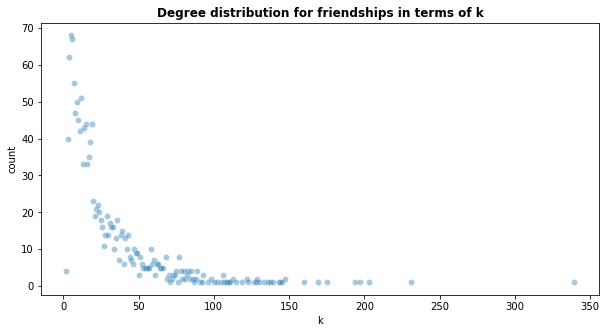

In [5]:
# Define axs and figure
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
sns.scatterplot(data=dd, x="k", y="count", ax=ax, alpha=0.4)
ax.set_title(f"Degree distribution for friendships in terms of k", weight = "bold")

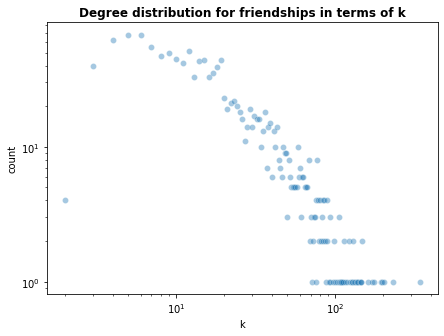

In [6]:
# Define axs and figure
fig, ax = plt.subplots(figsize=(7, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
sns.scatterplot(data=dd, x="k", y="count", ax=ax, alpha=0.4)
ax.set_title(f"Degree distribution for friendships in terms of k", weight = "bold")
ax.set_xscale('log')
ax.set_yscale('log')

# Save the plot
#if SAVE_FIG:
#    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_count_loglog.jpg")

In [7]:
ccdf = dd.sort_values(by = 'k', ascending = False)
ccdf['cumsum'] = ccdf['count'].cumsum()
ccdf['ccdf'] = ccdf['cumsum'] / ccdf['count'].sum()
ccdf = ccdf[['k', 'ccdf']].sort_values(by = 'k')

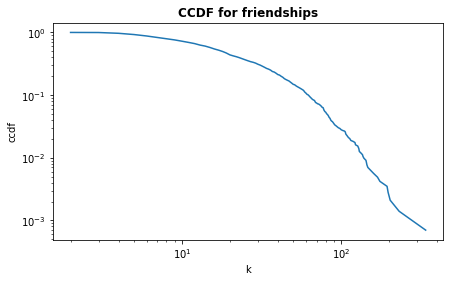

In [8]:
# Define axs and figure
fig, ax = plt.subplots(figsize=(7, 4))
plt.subplots_adjust(wspace=.3)

# Plot the data
sns.lineplot(data=ccdf, x="k", y="ccdf", ax=ax)
ax.set_title(f"CCDF for friendships", weight = "bold")
ax.set_xscale('log')
ax.set_yscale('log')

# Save the plot
#if SAVE_FIG:
#    plt.savefig(f"{PATH_TO['data']['figures']}/dd_bipartite_ccdf_loglog.jpg")

In [16]:
logcdf = np.log10(ccdf[["k", "ccdf"]])
x, y = logcdf['k'], logcdf['ccdf']

slope, log10intercept, r_value, p_value, std_err = linregress(x, y)
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope - 1, r_value ** 2, p_value))

ccdf["fit"] = (10 ** log10intercept) * (ccdf["k"] ** (slope))

CCDF Fit: 35.2272 x ^ -2.5381 (R2 = 0.8440, p = 0.0000)


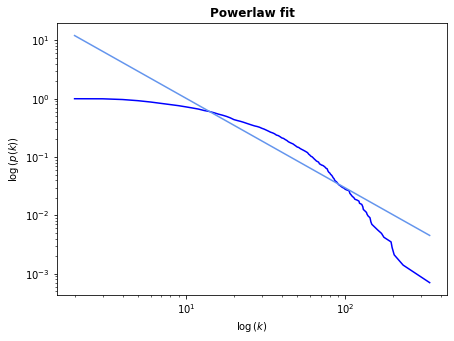

In [10]:
# Define axs and figure
fig, ax = plt.subplots(figsize=(7, 5))
plt.subplots_adjust(wspace=.3)

# Plot the data
sns.lineplot(data=ccdf, x="k", y="ccdf", color='blue', ax=ax)
sns.lineplot(data=ccdf, x='k', y='fit', color='cornflowerblue', ax=ax)
ax.set_title(f"Powerlaw fit", weight = "bold")
ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel('$\log{(k)}$')
plt.ylabel('$\log{(p(k))}$')

plt.savefig('powerlawfit')
plt.show()

## Centrality

In [11]:
d = {'Degree': list(nx.degree_centrality(G).values()), 
     'Closeness': list(nx.closeness_centrality(G).values()), 
     'Betweenness': list(nx.betweenness_centrality(G).values())}
df = pd.DataFrame(d)

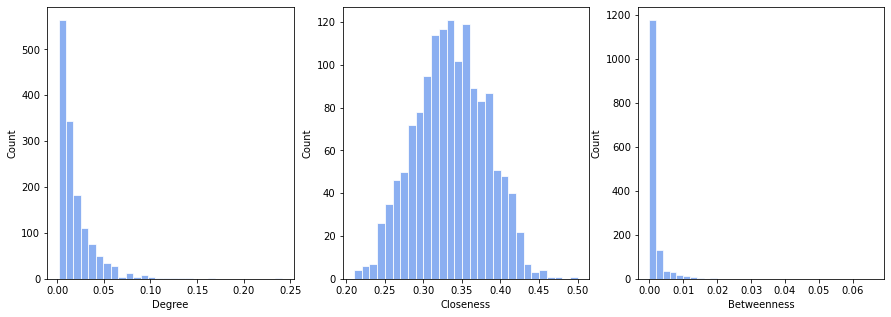

In [12]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

sns.histplot(df['Degree'], binwidth=0.008, color='cornflowerblue', edgecolor='white', ax=ax[0]);
sns.histplot(df['Closeness'], binwidth=0.01, color='cornflowerblue', edgecolor='white', ax=ax[1]);
sns.histplot(df['Betweenness'], binwidth=0.002, color='cornflowerblue', edgecolor='white', ax=ax[2]);

plt.savefig('distributions')

In [13]:
# Sort the dictionary items in descending order based on centrality values
sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[0]

('17', 0.23739495798319327)

In [14]:
sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)[0]

('17', 0.49207443142660234)

In [15]:
sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[0]

('17', 0.06579973319386656)